In [3]:
import numpy as np
import matplotlib.pyplot as plt
#import qutip as qt
from scipy.optimize import minimize
import random as rnd
import scipy
# Find the exact solution by hand

class Boltzmann_N_spins:
    """Class Boltzmann computes an optimal wave function for
    a given hamiltonian and initial w = a, b, W """
    def __init__(self, hamiltonian, n = 2):
        self.n = n
        self.hamiltonian = hamiltonian    # function which is defined outside
        self.w_optimal = np.nan    # optimal w = a, b, W      
        self.psi_optimal = np.nan    # optimal psi corresponding to the optimal w
        self.min_energy = np.nan    # minimal energy corresponding to the optimal psi
        self.energy_optimization_history = []
        
    ########### PSI #################################
    
    def psi_M(self, S, w):    # Works for complex w, however, runtime errors
        """Returns a component of a wavefunction
        in the S direction
        psi is given in form of an array and works for any number of spins"""
        a, b, W = w[0], w[1], w[2]
        psi = np.exp(np.sum(a * S))
#         print('W ===', len(W))
        for i in range(len(W)):
            Fi = 2 * np.cosh(b[i] + np.sum(W[i] * S))
            psi *= Fi
        return psi

    def compute_psi(self, w):
        """Computes psi for w = a,b,W 
        psi is given in form of an array and works for any number of spins"""
        n = len(w[0])
        s = generate_spins(n)
        psi = np.zeros(2 ** n, dtype = 'complex')
        for i in range(len(psi)):
            psi[i] = self.psi_M(s[i], w)
        return psi
    
    def compute_psi_scipy(self, w_scipy):
        """Computes psi when for a given w_scipy"""
        w = self.convert_w_from_scipy(w_scipy)
        return self.compute_psi(w)
    
    def normalize(self, psi):
        """Returns normalized psi"""
        psi_star = np.transpose(np.conjugate(psi))
        return psi / np.sqrt(np.sum(psi_star @ psi))
        
    def show_psi(self, psi):
        """psi is a vector with lenght 2^n"""
        s = 'psi = '
        accuracy = '%.2f'
        for i in range(len(psi)):
            basis = bin(i)
            while len(basis) < len(bin(len(psi))) - 1:
                basis = basis[0:2] + '0' + basis[2:]
            if np.real(psi[i]) >= 0:
#                 s += '(' + str('%.5f' % np.real(psi[i])) + ' + i' + str('%.5f' % np.imag(psi[i])) + ')|' + basis[2:] + '>' + ' + '
                s += '(' + str(accuracy % np.real(psi[i])) + ' + ' + str(accuracy % np.imag(psi[i])) + 'i)|' + basis[2:] + '>' + ' + '
            else:
                s += '(' + str(accuracy % np.real(psi[i])) + ' - ' + str(accuracy % np.imag(-psi[i])) + 'i)|' + basis[2:] + '>' + ' + '
        print(s[:-3])
    
    def show_psi_optimal(self):
        """Shows optimal psi"""
        if self.psi_optimal is np.nan:
            raise ValueError('The optimal psi is not computed yet')
        self.show_psi(self.psi_optimal)
    
    ########### PSI #################################
    ########### OMEGA ###############################
    
    def find_len_a(self, N):
        """Returns the size of a for a given length 
        N of w = a,b,W in a form of 1D array"""
        l = 0
        while 2 * l + l ** 2 != N:
            l += 1
        return l
    
    def convert_w_to_scipy(self, w):
        """Converts w = a, b, W into scipy form"""
        a, b, W = w[0], w[1], w[2]
        w_scipy = np.zeros(2 * (len(a) + len(b) + len(W) * len(W[0]))) # w_scipy = [real(a[0]), imag(a[0]), real(a[1]), ...]
        for i in range(len(a)):
            w_scipy[2 * i] = np.real(a[i])
            w_scipy[2 * i + 1] = np.imag(a[i])
        for i in range(len(b)):
            w_scipy[2 * (len(a) + i)] = np.real(b[i])
            w_scipy[2 * (len(a) + i) + 1] = np.imag(b[i])
        for i in range(len(W)):
            for j in range(len(W[0])):
                w_scipy[2 * (len(a) + len(b) + i * len(W) + j)] = np.real(W[i][j])
                w_scipy[2 * (len(a) + len(b) + i * len(W) + j) + 1] = np.imag(W[i][j])
        return w_scipy
    
    def convert_w_from_scipy(self, w_scipy):
        """From w in scipy form returns w = a, b, W"""
        w = np.zeros(len(w_scipy) // 2, dtype = 'complex')
        for i in range(len(w)):
            w[i] = w_scipy[2 * i] + 1j * w_scipy[2 * i + 1]
        l = self.find_len_a(len(w))
        a, b = w[:l], w[l : 2 * l]
        W = np.resize(w[2 * l + 1:], (l, l))
        return a, b, W
    
    def show_omega_optimal(self):
        """Shows optimal w"""
        w = self.w_optimal
        a, b, W = w[0], w[1], w[2]
        print('a = ', a, '\nb = ', b, '\nW = ', W)
        
    ########### OMEGA ###############################
    ########### ENERGY ##############################
    
    def avg_energy(self, psi):
        """Returns the average energy for a given  wavefunciton
        and a given hamiltonian
         =  / """
        psi_star = np.transpose(np.conjugate(psi))
        return np.sum(psi_star @ self.hamiltonian(n,h)@ psi) / np.sum(psi_star * psi)
    
    def avg_energy_scipy(self, w_scipy):
        """Returns the average energy for a given configuration w,
        made to work for scipy.optimize.minimize
        Size of w is 2N, even is real, odd is complex"""
        psi = self.compute_psi_scipy(w_scipy)
        self.energy_optimization_history.append(self.avg_energy(psi))
        return np.real(self.avg_energy(psi))
#         return self.avg_energy(psi)
    
    def show_min_energy(self):
        if self.min_energy is np.nan:
            raise ValueError('The optimal energy is not computed yet')
        s = 'E_min = ' + str(self.min_energy)
        print(s)
    
    ########### ENERGY ##############################
    ########### OPTIMIZATION ########################
    
    def find_optimal_psi(self, w0, tolerance = None):
        """For a given hamiltonian searches for the
        ground state, i.e. the psi which minimizes the energy"""
        w0_scipy = self.convert_w_to_scipy(w0)
#         w_min = minimize(self.avg_energy_scipy, w0_scipy)    # x0 is now complex, size 2N, even spots real, odd imag
        w_min = minimize(self.avg_energy_scipy, w0_scipy, tol = tolerance)    # x0 is now complex, size 2N, even spots real, odd imag
        w_optimal_scipy = w_min.x
        self.w_optimal = self.convert_w_from_scipy(w_optimal_scipy)    # w_optimal is in a, b, W form
        self.psi_optimal = self.compute_psi(self.w_optimal)
        self.min_energy = self.avg_energy(self.psi_optimal)
    
    ########### OPTIMIZATION ########################
    

def normalize(psi):
        """Returns normalized psi"""
        psi_star = np.transpose(np.conjugate(psi))
        return psi / np.sqrt(np.sum(psi_star @ psi))

########### NEW HAMILTONIAN #########################
"""Here N is the nmber of spins/particles"""

def sigma_x(N):
    """Applies sigma_x_i in form of tensor product"""
    sigma_matrix = np.matrix([[0,1],[1, 0]])
    ones_matrix = np.identity(2)
    final_hamiltonian = 0
    a = sigma_matrix
    for i in range(N):
        for j in range(1,N):
            if i == j:
                a = np.kron(a, sigma_matrix)
            else:
                a = np.kron(a, ones_matrix)
            
        final_hamiltonian += a
        a = ones_matrix
              
    return final_hamiltonian

def sigma_z_double(N):
    """Applies sum sigma_z_i sigma_z_{i+1}
    on a given wavefunction psi and returns the 
    new wavefunciton"""
    n=2**N
    psi1 = np.identity(n)
    s = generate_spins(N)
    if N == 2:
        for i in range(n):
            for j in range(N):
                psi1[i, i] *= s[i,j]
    else: 
        psi1 = np.zeros((n,n))
        for i in range(n):
            for j in range(N):
                psi1[i][i] += (-1) ** (1 + (s[i][j] + s[i][(j + 1) % len(s[0])]) // 2) 
    return psi1



def hamiltonian(N, h):
    return scipy.sparse.csr_matrix(-h*sigma_x(N)-sigma_z_double(N))

def generate_spins(n):
    s = np.zeros((2 ** n, n))
    for i in range(2 ** n):
        b = bin(i)
        while len(b) < n + 2:
            b = b[0:2] + '0' + b[2:]
        d = []
        for k in b:
            if k == '0':
                d.append(-1)
#                     d.append(0)    # This could be more convenient, we'll see
            else:
                d.append(1)
        s[i] = np.array(d[2:])
    return s

########### NEW HAMILTONIAN #########################

In [36]:
### INITIALIZATION ########################
n = 2
a = np.random.rand(n)
b = np.random.rand(n)
W = np.random.rand(n,n) + 1j * np.random.rand(n,n)
w = a, b, W
h = 0.5
boltzmann = Boltzmann_N_spins(hamiltonian, n)
########### INITIALIZATION ########################

########### OPTIMZATION ###########################
tolerance = 0.01
boltzmann.find_optimal_psi(w)
########### OPTIMZATION ###########################

########### EXTRACTING PARAMETERS #################
w_optimal = boltzmann.w_optimal
psi_optimal = boltzmann.psi_optimal
boltzmann.psi_optimal = normalize(psi_optimal)
min_energy = boltzmann.min_energy
########### EXTRACTING PARAMETERS #################


In [37]:
boltzmann.show_psi_optimal()
boltzmann.show_min_energy()
# boltzmann.show_omega_optimal()

psi = (0.65 + -0.08i)|00> + (0.27 + -0.03i)|01> + (0.27 + -0.03i)|10> + (0.65 + -0.08i)|11>
E_min = (-1.4142135623678427+3.818740845724347e-17j)


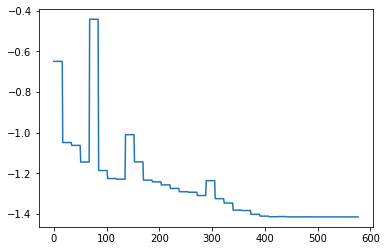

In [38]:
plt.plot(np.real(boltzmann.energy_optimization_history))

In [14]:
psi = boltzmann.compute_psi(w)
boltzmann.show_psi(psi)

psi = (-1.50 - 5.97i)|000> + (3.03 + 2.76i)|001> + (-0.40 - -0.25i)|010> + (97.63 + 13.25i)|011> + (3.90 + -1.60i)|100> + (-2.86 - -12.51i)|101> + (2.78 + 6.46i)|110> + (-253.32 - 591.12i)|111>


In [60]:
###Functions to optimize the markow chain###
def psi_diference(S, w, ind):    # Works for complex w, however, runtime errors
    """Returns a result of division of wave function with fliped spi by initial psi """
    #s_new[ind] = spin which was flipped
    a, b, W = w[0], w[1], w[2]
    div_psi = np.exp(-2*a[ind]*S[ind])+ 1j
    p = store_constant(S, w)
    for i in range(len(W)):
        Fi_divided = (np.cosh(p[i]-2*W[i, ind]*S[ind]))/(np.cosh(p[i]))
        div_psi *= Fi_divided
    return div_psi

def store_constant(S, w):
    """Stores the constant (in form of array) to compute probapility (p) more eficcienly """
    a, b, W = w[0], w[1], w[2]
    p=np.zeros(len(b))
    for i in range(len(W)):
        p[i] = b[i] + np.sum(W[i] * S)
    return p
    

In [64]:
n = 3
a = np.random.rand(n)
b = np.random.rand(n)
W = np.random.rand(n,n) +1j*np.random.rand(n,n)
w = a, b, W
S = rnd.choice(generate_spins(n))
store_constant(S, w)
psi_diference(S, w, 2)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part


(0.15464028150533865-0.10031977059636232j)

In [17]:
def binary_to_decimal(s):
    """Returns the index correspoding to the state s"""
    ind = 0
    n = len(s)
    for i in range(n):
        if s[n - i - 1] == 1:
            ind += 2 ** i
    return ind

def index_of_spin(s):
    """Returns the index of a given spin"""
    n = len(s)
    ind = 0
    for i in range(n):
        if s[i] == 1:
            ind += 2 ** (n-i-1)
    return ind

def avg_energy_mc(w):
    """Computes average energy using stochastic
    gradient descent"""
    N_steps = 10000
    S = generate_spins(len(w[0]))
    s = rnd.choice(generate_spins(len(w[0])))
    s_hist = np.zeros(len(S))
    E = np.zeros(N_steps)
    for i in range(N_steps):
        E[i], s = monte_carlo_step(s, w, hamiltonian, boltzmann)
#         print(np.argwhere(S == s)[0])
        s_hist[index_of_spin(s)] +=1
#     return np.zeros(N_steps), s_hist
#     return E, s_hist
    return np.average(E), s_hist

def monte_carlo_step(s, w, hamiltonian, boltzmann):
    """For a given pure state in a given hamiltonian,
    does a monte_carlo_step on a pure state"""
    n_spin = len(s)
#     a, b, W = w[0], w[1], w[2]
    ind = rnd.randint(0, n_spin - 1)
    s_new = s.copy()
    s_new[ind] *= -1
    # We compute the probability to accept the modification
    # as the ratio of psi_M(s_new) and psi_M(s)
    psi_M, psi_M_new = boltzmann.psi_M(s, w), boltzmann.psi_M(s_new, w)    
    
    p = np.abs(psi_diference(s, w, ind) * np.conjugate(psi_diference(s, w, ind)))
   
    if rnd.random() < p:
        print(s)
        s = s_new
        print(s_new)
        print('***')
    else:
        print('REJECTED')
    # computing the change in the energy
    delta_E_mc = 0
    s_new = s.copy()
    for i in range(len(s)):    # sigma_x
        s_new[i] *= -1
        delta_E_mc += (-h) * psi_diference(s, w, ind)
        s_new[i] *= -1
    if len(s) == 2:
        delta_E_mc -= s[0] * s[1]    # double_sigma_z for 2 spins
    else:
        delta_E_mc -= sum(s[i] * s[(i + 1) % len(s)] for i in range(len(s)))    # double_sigma_z
    return delta_E_mc, s

def delta_E_mc_sigma_x(s):
    """Returns the enregy contribution of sigma_x
    to the stochastic energy"""
    E = 0
    for i in range(len(s)):
        E += (-h) * boltzmann.psi_M()

In [18]:
E, s_hist = avg_energy_mc(w_optimal)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: ComplexWarning: Casting complex values to real discards the imaginary part


REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
[-1. -1.  1.]
[-1. -1. -1.]
***
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJECTED
REJEC

In [19]:
print('E = ', E)

E =  -2.993914948266509


In [20]:
def plot_psi_M_probability(w, boltzmann):
    a, b, W = w[0], w[1], w[2]
    S = generate_spins(len(W))
    p = np.zeros(len(S), dtype = 'complex')
    for i in range(len(S)):
#         print(s)
        p[i] = np.real(np.transpose(np.conjugate(boltzmann.psi_M(S[i], w))) * boltzmann.psi_M(S[i], w))
#         print(p[i])
    plt.plot(p)
    return p

/opt/conda/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


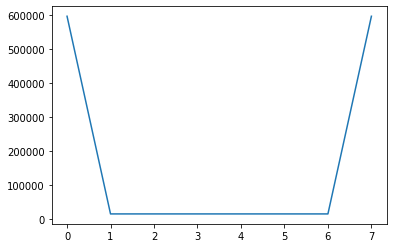

In [21]:
p = plot_psi_M_probability(w_optimal, boltzmann)

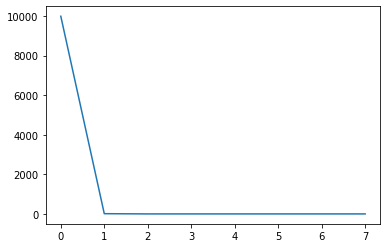

In [22]:
plt.plot(s_hist)

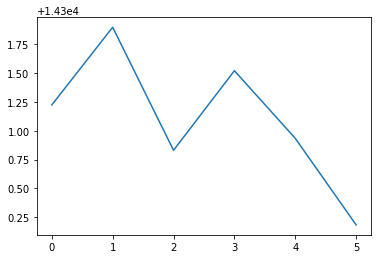

In [23]:
plt.plot(p[1:-1])

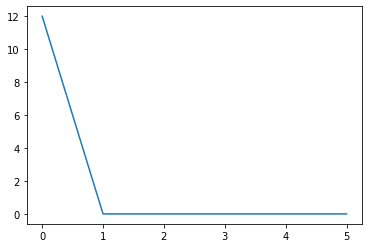

In [24]:
plt.plot(s_hist[1:-1])

In [25]:
x = s_hist


Text(0, 0.5, 'Weight')

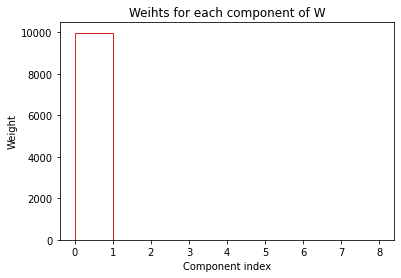

In [35]:
plt.stairs(x, color='tab:red')
plt.title('Weihts for each component of W')
plt.xlabel('Component index')
plt.ylabel('Weight')

# Compare physical values

In [27]:
###Code to compute physical value "C" from data obtained using algorithm###
def sigma_z_0_l(psi, l):
    """Applies  sigma_z_0 sigma_z_{l}
    on a given wavefunction psi and returns the 
    new wavefunciton"""
    n_spins = int(np.log2(len(psi)))
    s = generate_spins(n_spins)
    psi_sigma_z = np.zeros(len(psi), dtype = 'complex')
    for i in range(len(psi_sigma_z)):
        psi_sigma_z[i] = s[i][0] * s[i][l] * psi[i]
    return psi_sigma_z

def spin_correlation(psi):
    """Returns array C which contains the correlation between
    the spin at position 0 and the spin on position i. C is
    of the length N_spins + 1, and C[-1] is set to C[0] 
    for visual purposes"""
    psi = normalize(psi)
    psi_star = np.transpose(np.conjugate(psi))
    n_spins = int(np.log2(len(psi)))
    C = np.zeros(n_spins + 1)
    for i in range(n_spins):
        C[i] = psi_star @ sigma_z_0_l(psi, i)
        print(C)
    C[-1] = C[0]
    return C

In [29]:
C = spin_correlation(psi_optimal)

[1. 0. 0. 0.]
[1.         0.91068193 0.         0.        ]
[1.         0.91068193 0.91068415 0.        ]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: ComplexWarning: Casting complex values to real discards the imaginary part


In [31]:
###Code to compute exact value of "C" ###
def sigma_x_exact(N):
    """Applies sigma_x_i in form of tensor product"""
    sigma_matrix = np.matrix([[0,1],[1, 0]])
    ones_matrix = np.identity(2)
    final_hamiltonian = 0
    a = sigma_matrix
    for i in range(N):
        for j in range(1,N):
            if i == j:
                a = np.kron(a, sigma_matrix)
            else:
                a = np.kron(a, ones_matrix)
            
        final_hamiltonian += a
        a = ones_matrix
              
    return final_hamiltonian

def sigma_z_exact(N):
    """Applies sum sigma_z_i sigma_z_{i+1}
    on a given wavefunction psi and returns the 
    new wavefunciton"""
    n=2**N
    psi1 = np.identity(n)
    s = generate_spins(N)
    if N == 2:
        for i in range(n):
            for j in range(N):
                psi1[i, i] *= s[i,j]
    else: 
        psi1 = np.zeros((n,n))
        for i in range(n):
            for j in range(N):
                psi1[i][i] += (-1) ** (1 + (s[i][j] + s[i][(j + 1) % len(s[0])]) // 2) 
    return psi1



def hamiltonian_for_N_exact(N, h=-1):
    return -h*sigma_x_exact(N)-sigma_z_exact(N)


def normalize_exact(N):
    """Gets psi from Hamiltonian and returns normalized psi"""
    H = hamiltonian_for_N_exact(N, 0.5)
    eig_H = np.linalg.eig(H)
    index_eigen_vector = np.argmin(eig_H[0])
    psi = eig_H[1][:,[index_eigen_vector]] #it's eigenvector for the ground state
    psi_star = np.transpose(np.conjugate(psi))
    
    return psi / np.sqrt(np.sum(psi_star @ psi))
        
def sigma_z_0_l_exact(N, l):
    """Applies  sigma_z_0 sigma_z_{l}
    on a given wavefunction psi and returns the 
    new wavefunciton"""
    n = 2**N
    n_spins = N
    s = generate_spins(n_spins)
    #print(s)
    sigma_z = np.zeros(n)
    for i in range(n):
        sigma_z[i] = (s[i][0] * s[i][l])
        #print(i, sigma_z[i])
    return np.diag(sigma_z)

def spin_correlation_exact(N):
    #psi_complex = np.zeros(2**N, dtype = 'complex')
    #for i in range(len(psi)):
    #    psi_complex[i] = psi[i]
    psi = normalize_exact(N)
    psi_star = np.transpose(np.conjugate(psi))
    
    n_spins = int(N)
    C = np.zeros(n_spins + 1)
    for i in range(n_spins):
        C[i] = np.real(psi_star @ sigma_z_0_l_exact(N, i)@psi)
        print(C)
    C[-1] = C[0]
    return C

In [ ]:
hamiltonian_for_N_exact(N, h=-1)

In [32]:
N= 3
C_exact=spin_correlation_exact(N)

[1. 0. 0. 0.]
[1.        0.9106836 0.        0.       ]
[1.        0.9106836 0.9106836 0.       ]


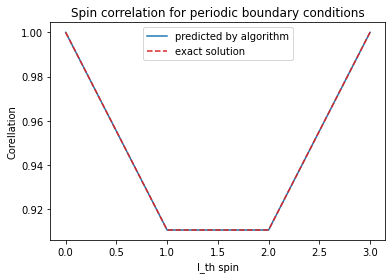

In [34]:
plt.plot(np.real(C),color='tab:blue', linestyle='-', label="predicted by algorithm")
plt.plot(C_exact, color='tab:red', linestyle='--', label="exact solution" )
plt.title('Spin correlation for periodic boundary conditions')
plt.xlabel('l_th spin')
plt.ylabel('Corellation')
plt.savefig('Figures\\Spin correlation ' + str(n) + ' spins, h = ' + str(h) + '.png')
plt.legend()
